# Dowscaled Climate Data Analysis

Doewnscaled CMIP6 data (CNN and U-Net) were compared with CMIP6, NEX-GDDP. 

CNN architecture consists of an encoder with 31 convolutional layers (using increasing filter sizes of 32, 64, and 128) and a decoder with 16 transposed convolutional layers (with decreasing filter sizes), connected by skip connections every two layers to preserve spatial details, all maintaining the input dimensions throughout the network through 'same' padding (no downsampling/upsampling performed).

U-Net architecture features 5 encoder/decoder blocks with progressive filter sizes (64 to 512), incorporating attention mechanisms, residual connections, and channel attention in the decoder path. The network includes skip connections between corresponding encoder-decoder levels and a final residual connection from input to output.

Other architectures found in the literature to be tested: vision transformers adapted for climate data, advanced CNN variants (ResNet with deconvolution layers), GANs (Generative Adversarial Networks).



In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

## Define Functions for Data Loading and Plotting
In this section, are defined helper functions to load data, calculate statistics, and plot results.

In [5]:
# Function to load datasets and calculate multiannual means
def load_and_mean_data(files_or_path, var_name, mask=None, lat=None, lon=None, interp_method=None, is_zarr=False):
    """Load the dataset, calculate the multiannual mean, and apply the mask."""
    if is_zarr:
        ds = xr.open_zarr(files_or_path, consolidated=True)
    else:
        ds = xr.open_mfdataset(files_or_path, combine='by_coords', chunks={'time': -1})
    
    data_mean = ds[var_name].mean(dim='time')
    
    # Interpolate if lat/lon are provided
    if lat is not None and lon is not None and interp_method:
        data_mean = data_mean.interp(lat=lat, lon=lon, method=interp_method, kwargs={"fill_value": "extrapolate"})
    
    # Apply mask if provided
    if mask is not None:
        data_mean = data_mean.where(~mask, np.nan)
    
    return data_mean

# Function to plot mean temperature maps
def plot_map(data, ax, title, mean_value, vmin=270, vmax=292, cmap='RdBu_r'):
    data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax,
        cbar_kwargs={'orientation': 'horizontal', 'pad': 0.05, 'shrink': 0.8, 'aspect': 30, 'label': 'Mean Temperature (K)'}
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, edgecolor='gray')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax.set_title(title)
    ax.text(10, 50.5, f'Mean: {mean_value:.2f} K', fontsize=10, ha='center', va='center', color='black')

# Function to calculate RMSE
def calculate_rmse(model1, model2):
    """Calculate Root Mean Square Error (RMSE) between two models."""
    return np.sqrt(np.nanmean((model1 - model2) ** 2))

# Function to calculate MAE
def calculate_mae(model1, model2):
    """Calculate Mean Absolute Error (MAE) between two models."""
    return np.nanmean(np.abs(model1 - model2))

## Load Historical Data 
Load the historical datasets (CMIP6, NEX-GDDP, CNN, U-Net), calculate the multiannual means, and plot the results.

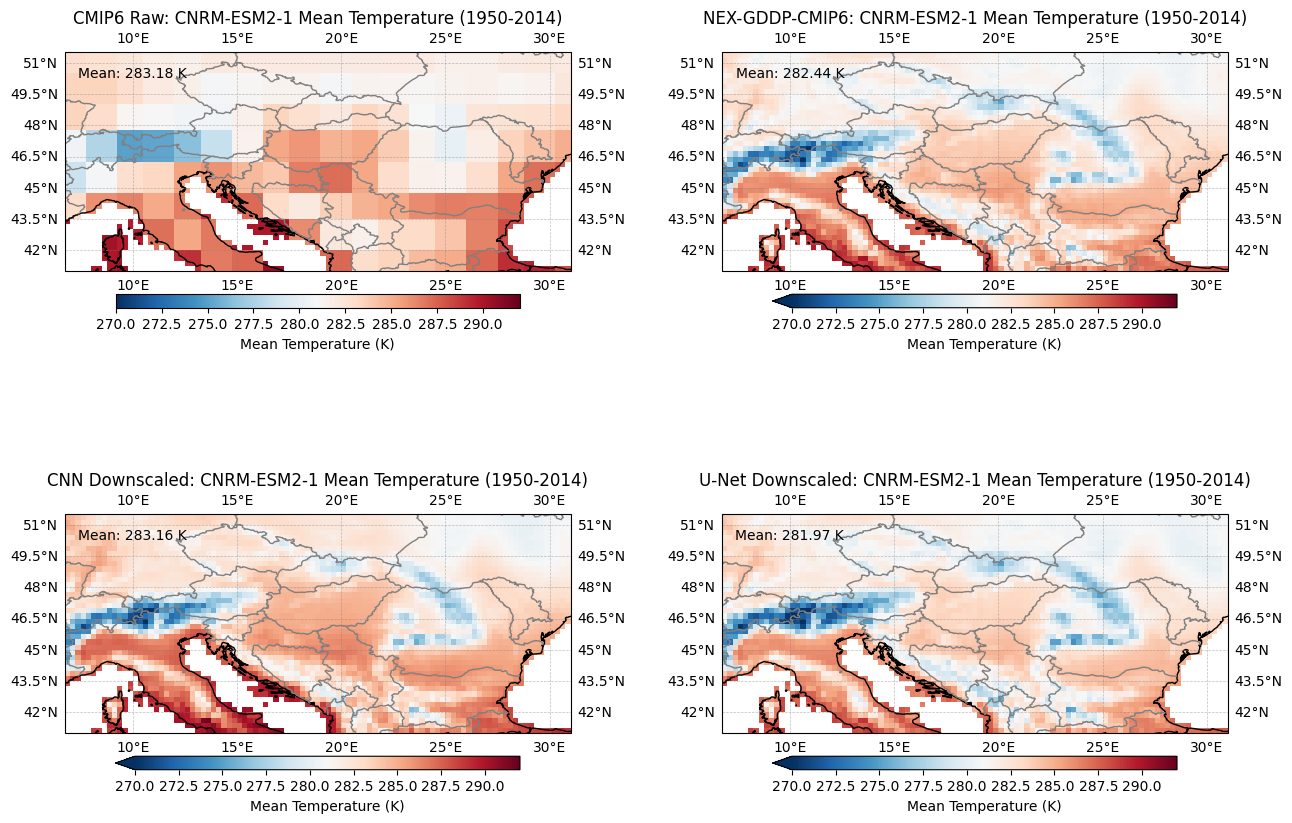

In [7]:
# Define file paths for historical data
nexgddp_base_path = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/CNRM-ESM2-1'
cmip6_base_path = '/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1'

nexgddp_hist_files = [f'{nexgddp_base_path}/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_{year}_rou.nc' for year in range(1950, 2015)]
cmip6_hist_file = f'{cmip6_base_path}/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cnn_hist_file = 'ncs/cnn/predicted_high_res_tas_encod_v02.nc'
unet_hist_file = 'ncs/unet/predicted_high_res_tas_unet_v02.nc'

# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'tas')
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon

# Load CMIP6 data and interpolate
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True)

# Load CNN and U-Net downscaled data
cnn_mean_hist = load_and_mean_data(cnn_hist_file, 'tas_downscaled', mask=mask_nexgddp_na)
unet_mean_hist = load_and_mean_data(unet_hist_file, 'tas_downscaled', mask=mask_nexgddp_na)

# Plot multiannual means for historical data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0, wspace=0.3)

# Plot each dataset for historical data
plot_map(cmip6_mean_hist, axs[0, 0], 'CMIP6 Raw: CNRM-ESM2-1 Mean Temperature (1950-2014)', cmip6_mean_hist.mean().values)
plot_map(nexgddp_mean_hist, axs[0, 1], 'NEX-GDDP-CMIP6: CNRM-ESM2-1 Mean Temperature (1950-2014)', nexgddp_mean_hist.mean().values)
plot_map(cnn_mean_hist, axs[1, 0], 'CNN Downscaled: CNRM-ESM2-1 Mean Temperature (1950-2014)', cnn_mean_hist.mean().values)
plot_map(unet_mean_hist, axs[1, 1], 'U-Net Downscaled: CNRM-ESM2-1 Mean Temperature (1950-2014)', unet_mean_hist.mean().values)

plt.show()

## Load and Plot SSP245 Scenario Data
The data from the SSP245 scenario for the same set of models (CMIP6, NEX-GDDP, CNN, U-Net). This data covers the period from 2015 to 2100.

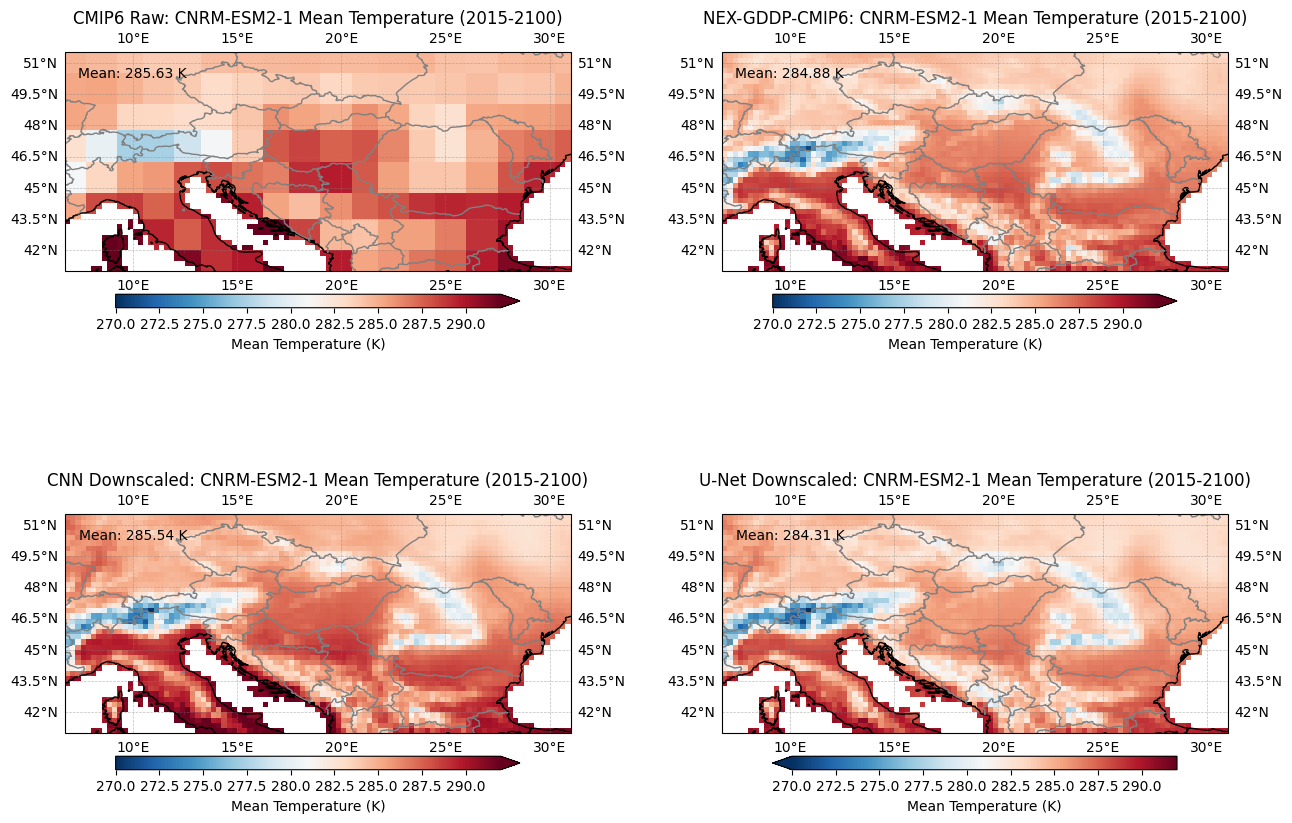

In [8]:
# Define file paths for SSP245 scenario
nexgddp_ssp_files = [f'{nexgddp_base_path}/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_{year}_rou.nc' for year in range(2015, 2101)]
cmip6_ssp_file = f'{cmip6_base_path}/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cnn_ssp_file = 'ncs/cnn/predicted_high_res_tas_encod_ssp245.nc'
unet_ssp_file = 'ncs/unet/predicted_high_res_tas_ssp245.nc'

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas')
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True)

# Load CNN and U-Net downscaled data for SSP245
cnn_mean_ssp = load_and_mean_data(cnn_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na)
unet_mean_ssp = load_and_mean_data(unet_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na)

# Plot multiannual means for SSP245 data
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw: CNRM-ESM2-1 Mean Temperature (2015-2100)', cmip6_mean_ssp.mean().values)
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6: CNRM-ESM2-1 Mean Temperature (2015-2100)', nexgddp_mean_ssp.mean().values)
plot_map(cnn_mean_ssp, axs[1, 0], 'CNN Downscaled: CNRM-ESM2-1 Mean Temperature (2015-2100)', cnn_mean_ssp.mean().values)
plot_map(unet_mean_ssp, axs[1, 1], 'U-Net Downscaled: CNRM-ESM2-1 Mean Temperature (2015-2100)', unet_mean_ssp.mean().values)

plt.show()

## Plot Differences for SSP245 Data
Calculate the differences between the NEX-GDDP, CNN, and U-Net models in comparison to the CMIP6 raw data for the SSP245 scenario.

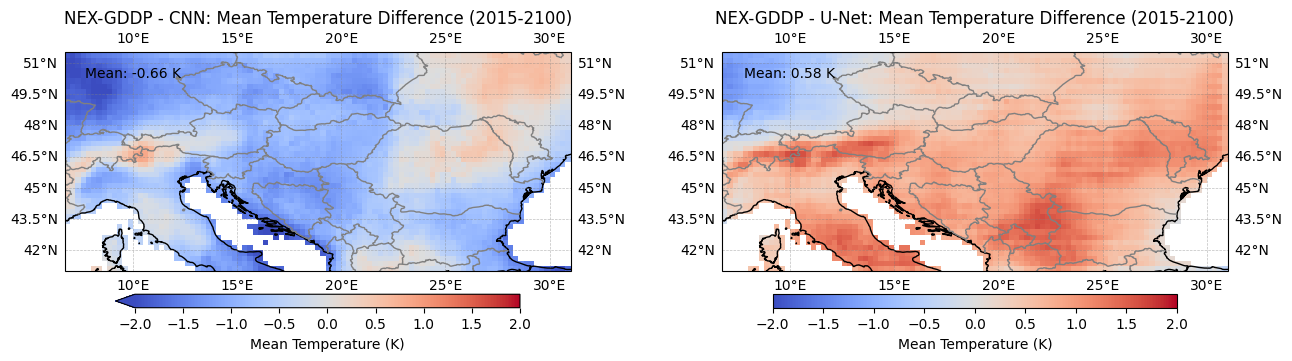

In [9]:
# Plot differences for SSP245
fig, axs = plt.subplots(1, 2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(wspace=0.3)

# Calculate and plot differences
nexgddp_cnn_diff_ssp = nexgddp_mean_ssp - cnn_mean_ssp
nexgddp_unet_diff_ssp = nexgddp_mean_ssp - unet_mean_ssp

# Plot difference: NEX-GDDP - CNN
plot_map(nexgddp_cnn_diff_ssp, axs[0], 'NEX-GDDP - CNN: Mean Temperature Difference (2015-2100)', nexgddp_cnn_diff_ssp.mean().values, vmin=-2, vmax=2, cmap='coolwarm')

# Plot difference: NEX-GDDP - U-Net
plot_map(nexgddp_unet_diff_ssp, axs[1], 'NEX-GDDP - U-Net: Mean Temperature Difference (2015-2100)', nexgddp_unet_diff_ssp.mean().values, vmin=-2, vmax=2, cmap='coolwarm')

plt.show()

## Calculate RMSE and MAE for SSP245 Scenario and plot global mean for the selected domain
Calculate the RMSE and MAE between the downscaled models (NEX-GDDP, CNN, U-Net) and the CMIP6 raw data for the SSP245 scenario.

/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 365. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


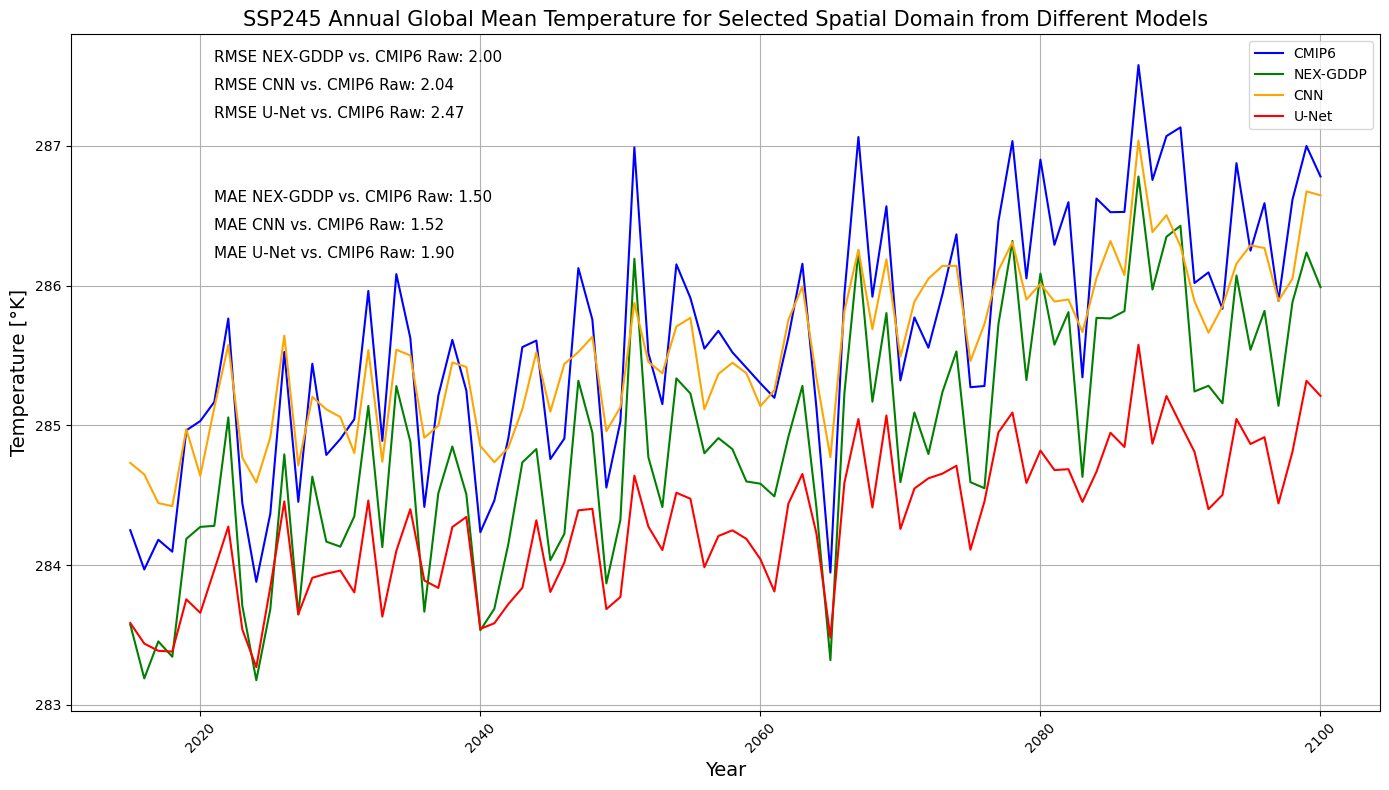

In [42]:
# Define file paths for SSP245 scenario
nexgddp_ssp_files = [f'{nexgddp_base_path}/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_{year}_rou.nc' for year in range(2015, 2101)]
cmip6_ssp_file = f'{cmip6_base_path}/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cnn_ssp_file = 'ncs/cnn/predicted_high_res_tas_encod_ssp245.nc'
unet_ssp_file = 'ncs/unet/predicted_high_res_tas_ssp245.nc'

nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()


# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True, chunks={'time': 365})
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest', kwargs={"fill_value": "extrapolate"})

cmip6_annual = cmip6_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na, np.nan)
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])

# Load and process CNN data
cnn_ds = xr.open_dataset(cnn_ssp_file, chunks={'time': 365})
cnn_annual = cnn_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na, np.nan)
cnn_global_mean = cnn_annual.mean(dim=['lat', 'lon'])

# Load and process U-Net data
unet_ds = xr.open_dataset(unet_ssp_file, chunks={'time': 365})
unet_annual = unet_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na, np.nan)
unet_global_mean = unet_annual.mean(dim=['lat', 'lon'])

# Function to calculate RMSE and MAE
def calculate_rmse_mae(model1, model2):
    diff = model1 - model2
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Calculate RMSE and MAE values
rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(cmip6_annual.values, nexgddp_annual.values)
rmse_cnn, mae_cnn = calculate_rmse_mae(cmip6_annual.values, cnn_annual.values)
rmse_unet, mae_unet = calculate_rmse_mae(cmip6_annual.values, unet_annual.values)

# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(14, 8))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='blue')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, cnn_global_mean.values, label='CNN', color='orange')
plt.plot(years, unet_global_mean.values, label='U-Net', color='red')

# Customize the plot
plt.title('SSP245 Annual Global Mean Temperature for Selected Spatial Domain from Different Models', fontsize=15)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature [°K]', fontsize=14)
plt.legend()
plt.grid()
plt.xticks(rotation=45)

# Add RMSE and MAE values to the plot
text_y_positions = [287.6, 287.4, 287.2, 286.6, 286.4, 286.2]
for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_cnn, rmse_unet],
        [mae_nexgddp, mae_cnn, mae_unet],
        ['NEX-GDDP', 'CNN', 'U-Net'])):
    plt.text(2021, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.2f}', fontsize=11)
    plt.text(2021, text_y_positions[i+3], f'MAE {label} vs. CMIP6 Raw: {mae:.2f}', fontsize=11)

# Adjust subplot parameters for better layout
plt.tight_layout()
plt.show()

### Next steps

Test the two models using all CMIP6 scenarios. 
Adapt the models for multi-parameter (multi-variable) climate downscaling within a single realization. 